In [99]:
import pandas as pd
import numpy as np
import time


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from kmodes.kprototypes import KPrototypes

from sklearn.metrics import silhouette_score

from collections import Counter

# Max columns setting for Dataframe display
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 1000)



In [100]:
# Import sound to play when computation is ready
import winsound
duration = 1000  # milliseconds
freq = 200  # Hz
play_sound = winsound.Beep(freq, duration)

In [101]:
df = pd.read_csv('20231227_churn_data.csv')
df_churn  = df.dropna(subset=['year_end_policy'], axis=0)
df_churn_check = df_churn[['policy_nr_hashed', 'year_initiation_policy_version', 'year_end_policy', 'd_churn','welcome_discount', 'welcome_discount_control_group']]
df_churn_check_disc = df_churn_check[df_churn_check['welcome_discount'] != 1.0]

df['postcode'].apply(type).unique()

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\2194792614.py:1: DtypeWarning: Columns (22,47,49,51,53,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('20231227_churn_data.csv')


array([<class 'int'>, <class 'str'>], dtype=object)

## Data Modification

In [103]:
def data_modification(df):
    # Remove mutations with Nan values
    df_dropped = df.drop(["mutation_1", "premium_change_mutation_1", "mutation_2", "premium_change_mutation_2",
                          "mutation_3", "premium_change_mutation_3", "mutation_4", "premium_change_mutation_4",
                          "mutation_5", "premium_change_mutation_5", "mutation_6", "premium_change_mutation_6",
                          "mutation_7", "premium_change_mutation_7", "mutation_8", "premium_change_mutation_8",
                          "mutation_9", "premium_change_mutation_9", "mutation_10", "premium_change_mutation_10",
                          "mutation_11", "premium_change_mutation_11", "mutation_12", "premium_change_mutation_12"],
                         axis=1, inplace=False)

    # Change NaN values of mutations to zero's
    df_mutation = (df[["mutation_1", "premium_change_mutation_1", "mutation_2", "premium_change_mutation_2",
                       "mutation_3", "premium_change_mutation_3", "mutation_4", "premium_change_mutation_4",
                       "mutation_5", "premium_change_mutation_5", "mutation_6", "premium_change_mutation_6",
                       "mutation_7", "premium_change_mutation_7", "mutation_8", "premium_change_mutation_8",
                       "mutation_9", "premium_change_mutation_9", "mutation_10", "premium_change_mutation_10",
                       "mutation_11", "premium_change_mutation_11", "mutation_12", "premium_change_mutation_12"]]
                   .fillna(0))

    # Add back the non-NaN valued mutations
    merged_df = pd.concat([df_dropped, df_mutation], axis=1)
    df = merged_df

    # The label encoder makes sure that categorical variables (object variables) are transformed to labels (numbers)
    label_encoder = LabelEncoder()
    df['welcome_discount_control_group_label'] = label_encoder.fit_transform(df['welcome_discount_control_group'])
    df['brand_label'] = label_encoder.fit_transform(df['brand'])
    df['type_label'] = label_encoder.fit_transform(df['type'])
    df['fuel_type_label'] = label_encoder.fit_transform(df['fuel_type'])
    df['product_label'] = label_encoder.fit_transform(df['product'])
    df['sales_channel_label'] = label_encoder.fit_transform(df['sales_channel'])
    df['policy_nr_hashed_label'] = label_encoder.fit_transform(df['policy_nr_hashed'])
    
    # Convert all elements to strings
    df['postcode'] = df['postcode'].astype(str)

    # Remove quotations if present
    df['postcode'] = df['postcode'].str.replace("'", "")
    
    df['postcode_label'] = label_encoder.fit_transform(df['postcode'])

    # Change NaN values of year-end policy to zero.
    # Note: this variable is might not usable in general for ML/ clustering
    # since 0 now will be associated with not churning.
    # This gives the variable incorrect predictive power.
    df["year_end_policy"] = df["year_end_policy"].fillna(0)

    return df


def drop_older_policies(df, year):
    return (df[df['year_initiation_policy'] >= year]
            .sort_values(by=['policy_nr_hashed', 'year_initiation_policy_version']))


def sum_cols(df, cols_to_sum, new_col_name):
    df[new_col_name] = df[cols_to_sum].sum(axis=1, min_count=1).fillna(0)
    df.drop(cols_to_sum, axis=1, inplace=True)
    return df


def add_treatment_vars(df):
    df['WD_eligible'] = 1
    df.loc[df['welcome_discount_control_group'].str.contains('no WD'), 'WD_eligible'] = 0
    df['LPA_eligible'] = 1
    df.loc[df['welcome_discount_control_group'].str.contains('no LPA'), 'LPA_eligible'] = 0
    df['eligibility_cat'] = (df['WD_eligible'] + 2*df['LPA_eligible']).astype(int)

    df_cs = df.groupby('policy_nr_hashed').agg(WD_level=('welcome_discount', 'min'))
    df = df.merge(df_cs, how='left', on='policy_nr_hashed')

    df['WD_received'] = 0
    df.loc[df['WD_level'] < 1, 'WD_received'] = 1

    return df


def shorten_postal_code(df, digits):
    for i in range(len(df['postcode'])):
        code = df.iloc[i, 10]
        try:
            df.iloc[i, 10] = float(code) // (10**(4-digits))
        except ValueError:
            df.iloc[i, 10] = 0

    df['postcode'].astype(int)
    return df


def minor_edits(df):
    # Apparently some rows are exactly identical, Luca said it was safe to drop these
    df = df.drop_duplicates(subset=['policy_nr_hashed', 'years_since_policy_started'], keep='last')

    # Recompute time periods as some seem to contain errors
    df['years_since_policy_started'] = (df['year_initiation_policy_version'] - df['year_initiation_policy']).astype(int)

    # Removes just over 200 datapoints that ended their policy in 2018 but still show up as a 2019 policy.
    df = df[df['year_end_policy'] != 2018]

    # Some of the postcode values are between quotations (e.g. 2045 is written as '2045').
    # We want to remove this so 2045 and '2045' are treated as the same postcode.
    # df['postcode'] = df['postcode'].str.replace("'", '')

    # Make d_churn=1 for a few cases where it is zero even though the year_end_policy clearly states they churn
    df.loc[df['year_initiation_policy_version'] == df['year_end_policy'], 'd_churn'] = 1

    # WD set to 1 if it is not the first year of the policy
    df.loc[df['years_since_policy_started'] != 0, 'welcome_discount'] = 1

    # Reduce accident-free years by 5 if it is mentioned in the mutation, changeNcbmData
    # rows added by Luca have nan values for premium_main_coverages and premium_supplementary_coverages
    df.loc[((df['premium_main_coverages'].isnull()) &
           ((df['mutation_1'] == 'changeNcbmData') | (df['mutation_2'] == 'changeNcbmData') |
            (df['mutation_3'] == 'changeNcbmData') | (df['mutation_4'] == 'changeNcbmData') |
            (df['mutation_5'] == 'changeNcbmData') | (df['mutation_6'] == 'changeNcbmData') |
            (df['mutation_7'] == 'changeNcbmData') | (df['mutation_8'] == 'changeNcbmData') |
            (df['mutation_9'] == 'changeNcbmData') | (df['mutation_10'] == 'changeNcbmData') |
            (df['mutation_11'] == 'changeNcbmData') |
            (df['mutation_12'] == 'changeNcbmData'))), 'accident_free_years'] -= 5

    # drop rows with churn in 2019 but 0 premium
    df = df[~((df['total_premium'] == 0) & (df['d_churn'] == 1) & (df['year_initiation_policy_version'] == 2019))]

    return df


# Preprocessing for 2018 (Note: Haven't used sum_cols and add_treatment_vars functions!!!!!!!)
df_2019_and_beyond = drop_older_policies(df,2019)
df_2019_and_beyond = data_modification(df_2019_and_beyond)
df_2019_and_beyond = minor_edits(df_2019_and_beyond)
df_2019_and_beyond.reset_index(drop=True, inplace=True)

# df_2019_and_beyond.postcode.unique()

In [68]:
# Splits df based on discount ranges
def create_discount_range_dataframes(df):
    # Define the bin edges
    bins = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05]
    
    # Create labels for the bins
    labels = ['0.7-0.75', '0.75-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.0', '1.0']
    
    # Create a new column with the bins
    df['discount_range'] = pd.cut(df['welcome_discount'], right = False, bins=bins, labels=labels, include_lowest=True)
    
    # Create separate DataFrames for each discount range
    grouped_dfs = {}
    for label in labels:
        grouped_dfs[label] = df[df['discount_range'] == label].copy()
    
    return grouped_dfs

# Example 
grouped_dfs = create_discount_range_dataframes(df)

# To retrive the dataframe for the range '0.7-0.75' write it as follows:
grouped_dfs['0.7-0.75']

# Might wanna rename the df's since the notation takes long to type. Let's say:
df_70_75 = grouped_dfs['0.7-0.75']    # for example


7

## Use clustering methods to create segments/clusters

In [104]:
# Assign df
df = df_2019_and_beyond

# Create a modified dataframe with only unique costumers and their first year observations
# There are some mistakes in the data, causing years_since_policy_started to be 1 or 2 for 
# 2021 iniciated plicies this is not possible so they are removed
df_unique = df[df.years_since_policy_started == 0]
df = df_unique
df

,policy_nr_hashed,years_since_policy_started,year_initiation_policy,year_initiation_policy_version,year_end_policy,d_churn,d_churn_cancellation,d_churn_between_prolongations,d_churn_around_prolongation,premium_main_coverages,premium_supplementary_coverages,total_premium,welcome_discount,welcome_discount_control_group,customer_age,accident_free_years,car_value,age_car,brand,type,weight,fuel_type,postcode,product,allrisk basis,allrisk compleet,allrisk royaal,wa-extra,wettelijke aansprakelijkheid,n_main_coverages,n_supplementary_coverages,n_coverages,sales_channel,data_collection_date,mutation_1,premium_change_mutation_1,mutation_2,premium_change_mutation_2,mutation_3,premium_change_mutation_3,mutation_4,premium_change_mutation_4,mutation_5,premium_change_mutation_5,mutation_6,premium_change_mutation_6,mutation_7,premium_change_mutation_7,mutation_8,premium_change_mutation_8,mutation_9,premium_change_mutation_9,mutation_10,premium_change_mutation_10,mutation_11,premium_change_mutation_11,mutation_12,premium_change_mutation_12,welcome_discount_control_group_label,brand_label,type_label,fuel_type_label,product_label,sales_channel_label,policy_nr_hashed_label,postcode_label
0,0WBV29B,0,2019,2019,0.0,0,0,0,0,3413.760,252.672,3666.432,1.00,no WD and no LPA,45,12,392067.2,7,volkswagen,PASSAT,1443,diesel,3509,Aegon Auto Op Maat Personenautoverzekering,0,0,0,0,1,1,1,2,Other,2023-12-15,0,0.0,0,0.00,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,66,980,2,0,2,0,1056
5,0WBV2JB,0,2019,2019,0.0,0,0,0,0,6824.384,252.224,7076.608,1.00,no WD and no LPA,75,17,347636.8,2,toyota,C-HR,1395,benzine,6105,Aegon Autoverzekering,0,1,0,0,1,2,1,3,Other,2023-12-15,0,0.0,0,0.00,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,63,351,1,1,2,1,2112
10,0WBV2R5,0,2019,2019,0.0,0,0,0,0,4845.120,252.672,5097.792,1.00,no WD and no LPA,48,23,434884.8,18,volvo,V70,1505,benzine,7621,Aegon Autoverzekering,0,0,0,1,1,2,1,3,Other,2023-12-15,0,0.0,0,0.00,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,67,1252,1,1,2,2,2713
15,0WBV2jp,0,2019,2019,2021.0,0,0,0,0,3178.560,0.000,3178.560,1.00,no WD and no LPA,68,10,496664.0,14,audi,A4,1490,diesel,7572,Aegon Autoverzekering,0,0,0,0,1,1,0,1,Other,2023-12-15,0,0.0,0,0.00,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,3,223,2,1,2,3,2684
17,0WBV2nn,0,2019,2019,0.0,0,0,0,0,3337.152,685.440,4022.592,1.00,no WD and no LPA,40,22,204422.4,7,ford,FIESTA,954,benzine,5971,Aegon Autoverzekering,0,1,0,0,1,2,1,3,Other,2023-12-15,0,0.0,0,0.00,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,22,624,1,1,2,4,2043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186141,zPmyylB,0,2021,2021,2023.0,0,0,0,0,12230.848,0.000,12230.848,1.00,WD and no LPA,56,31,1539003.2,2,porsche,CAYENNE,2295,electro,9606,Aegon Autoverzekering,0,0,1,0,1,2,0,2,Other,2023-12-15,0,0.0,0,0.00,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,52,394,3,1,2,93557,3483
186144,zPmyynd,0,2021,2021,2022.0,0,0,0,0,17485.440,0.000,17485.440,1.00,no WD and no LPA,35,9,2604918.4,7,porsche,CAYENNE,2215,benzine,1244,Aegon Autoverzekering,0,1,0,0,1,2,0,2,Other,2023-12-15,restoreCoverageForDamage,0.0,withdrawCoverageForDamage,0.00,restoreCoverageForDamage,0.0,applyRelationChange,245.952,withdrawCoverageForDamage,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,52,394,1,1,2,93558,124
186146,zPmyyxA,0,2021,2021,2022.0,0,0,0,0,5453.952,698.880,6152.832,1.00,WD and no LPA,28,0,726454.4,13,bmw,3-SERIE,1425,benzine,9581,Aegon Autoverzekering,0,0,0,1,1,2,1,3,Other,2023-12-15,changeNcbmData,0.0,replaceObjectAndChangeCoverage,154.56,0,0.0,0,0.000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,6,63,1,1,2,93559,3476
186148,zPmyz0O,0,2021,2021,2023.0,0,0,0,0,2526.720,0.000,2526.720,0.92,WD and n

## DBSCAN

In [105]:
# Assign df
df = df_2019_and_beyond

# Create a modified dataframe with only unique costumers and their first year observations
# There are some mistakes in the data, causing years_since_policy_started to be 1 or 2 for 
# 2021 iniciated plicies this is not possible so they are removed
df_unique = df[df.years_since_policy_started == 0]
df = df_unique

# Select certain variables of the dataframe for the clustering process
# Welscome_discount not used since we might want to use this later for comparing discount rates
# same goes for welcome_discount_control_group_label
df_cluster = df[["premium_main_coverages","premium_supplementary_coverages","total_premium","customer_age",
                 "accident_free_years","car_value","age_car","weight","allrisk basis","allrisk compleet","allrisk royaal",
                 "wa-extra","n_main_coverages","n_supplementary_coverages","n_coverages", 
                 "brand_label", "type_label", "fuel_type_label", "product_label", "sales_channel_label", "postcode_label"]]

################################################################################################################################
################################################################################################################################
# DBSCAN Clustering

# test on smaller dataset
# df_cluster_reduced = df_cluster.sample(n=200000 , random_state=42)
df_cluster_reduced = df_cluster

# Standardize
scaler = StandardScaler()
df_scaled_reduced = scaler.fit_transform(df_cluster_reduced)

start_time = time.time()

# Create DBSCAN object and fit the data
# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples is the number of samples in a neighborhood for a point to be considered as a core point
dbscan_1 = DBSCAN(eps=3, min_samples=5000)  
dbscan_1.fit(df_scaled_reduced)

end_time = time.time()
print(f"Excecution time: {end_time - start_time} seconds" )


# ANother fit with different epsilon
dbscan_2 = DBSCAN(eps=2.5, min_samples=5000)  
dbscan_2.fit(df_scaled_reduced)

end_time = time.time()

# Add cluster labels to the original DataFrame
df['cluster_dbscan_1'] = dbscan_1.labels_
df['cluster_dbscan_2'] = dbscan_2.labels_

print(f"Excecution time: {end_time - start_time} seconds")

Excecution time: 68.21615767478943 seconds
Excecution time: 83.39875888824463 seconds


C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\2044414208.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_dbscan_1'] = dbscan_1.labels_
C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\2044414208.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_dbscan_2'] = dbscan_2.labels_


In [109]:
np.unique(dbscan_1.labels_,return_counts = True)
np.unique(dbscan_2.labels_,return_counts = True)

(array([-1,  0,  1], dtype=int64), array([70834, 12283,  9386], dtype=int64))

## K-Prototypes

In [111]:
################################################################################################################################
################################################################################################################################
# K-prototypes Clustering

# Specify the categorical columns
categorical_columns = ['allrisk basis', 'allrisk compleet', 'allrisk royaal', 'wa-extra',
                       'n_main_coverages', 'n_supplementary_coverages', 'n_coverages',
                       'brand_label', 'type_label', 'fuel_type_label',
                       'product_label', 'sales_channel_label', "postcode_label"]

# Start timer to check computing time
start_time = time.time()

# Standardize the numerical data
numerical_columns = df_cluster.columns.difference(categorical_columns)
scaler = StandardScaler()
df_scaled_numerical = scaler.fit_transform(df_cluster[numerical_columns])

# Convert back to DataFrame
df_scaled_numerical_df = pd.DataFrame(df_scaled_numerical, columns=numerical_columns)

# Select categorical values
df_cluster_cat = df_cluster[categorical_columns]

# Reset indices of both DataFrames
df_scaled_numerical_df.reset_index(drop=True, inplace=True)
df_cluster_cat.reset_index(drop=True, inplace=True)

# Combine the scaled numerical data with the original categorical data along columns
df_scaled = pd.concat([df_scaled_numerical_df, df_cluster_cat], axis=1)

# i relates to the amount of segments
for i in [2,3,4,5,6,7]:
# for i in [5,6,7]:


    # Specify the number of clusters (you need to decide this based on your problem)
    num_clusters = i

    # Create KPrototypes object and fit the data
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', verbose=2, max_iter=14, n_init = 5)
    clusters = kproto.fit_predict(df_scaled, categorical=list(range(len(numerical_columns), len(df_scaled.columns))))

    # End timer
    end_time = time.time()

    # Check computing time
    print(f"Excecution time: {end_time - start_time} seconds" )
    # Add cluster labels to the original DataFrame
    df[f'cluster_k_prototypes_{i}'] = clusters


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/14, moves: 17716, ncost: 815354.266130369
Run: 1, iteration: 2/14, moves: 6307, ncost: 809255.0902158767
Run: 1, iteration: 3/14, moves: 3105, ncost: 807575.6120888315
Run: 1, iteration: 4/14, moves: 1612, ncost: 807104.9749030991
Run: 1, iteration: 5/14, moves: 848, ncost: 806973.9703602588
Run: 1, iteration: 6/14, moves: 427, ncost: 806940.540329528
Run: 1, iteration: 7/14, moves: 203, ncost: 806932.8814745424
Run: 1, iteration: 8/14, moves: 110, ncost: 806930.471906526
Run: 1, iteration: 9/14, moves: 76, ncost: 806929.2210366197
Run: 1, iteration: 10/14, moves: 47, ncost: 806928.7549222122
Run: 1, iteration: 11/14, moves: 28, ncost: 806928.6147821536
Run: 1, iteration: 12/14, moves: 12, ncost: 806928.590192215
Run: 1, iteration: 13/14, moves: 3, ncost: 806928.586070579
Run: 1, iteration: 14/14, moves: 4, ncos

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\1450146165.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'cluster_k_prototypes_{i}'] = clusters


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/14, moves: 23612, ncost: 766754.8967284876
Run: 1, iteration: 2/14, moves: 21053, ncost: 724527.4377850577
Run: 1, iteration: 3/14, moves: 12284, ncost: 713109.4177351308
Run: 1, iteration: 4/14, moves: 3285, ncost: 712448.3719215849
Run: 1, iteration: 5/14, moves: 1053, ncost: 712345.8512211036
Run: 1, iteration: 6/14, moves: 551, ncost: 712307.2932999076
Run: 1, iteration: 7/14, moves: 391, ncost: 712288.6184623499
Run: 1, iteration: 8/14, moves: 318, ncost: 712275.7755207547
Run: 1, iteration: 9/14, moves: 257, ncost: 712266.0460318177
Run: 1, iteration: 10/14, moves: 227, ncost: 712259.9678286238
Run: 1, iteration: 11/14, moves: 153, ncost: 712257.1273760402
Run: 1, iteration: 12/14, moves: 123, ncost: 712255.368162854
Run: 1, iteration: 13/14, moves: 80, ncost: 712254.6898397097
Run: 1, iteration: 14/14, moves: 32, ncost: 712254.5831374698
Init: initializing centroids
Init: initial

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\1450146165.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'cluster_k_prototypes_{i}'] = clusters


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/14, moves: 22662, ncost: 683753.3946800045
Run: 1, iteration: 2/14, moves: 11792, ncost: 672524.83617683
Run: 1, iteration: 3/14, moves: 6910, ncost: 668283.8181368035
Run: 1, iteration: 4/14, moves: 3906, ncost: 666929.887152369
Run: 1, iteration: 5/14, moves: 2025, ncost: 666609.7062877137
Run: 1, iteration: 6/14, moves: 877, ncost: 666513.7077747169
Run: 1, iteration: 7/14, moves: 651, ncost: 666429.6112584911
Run: 1, iteration: 8/14, moves: 878, ncost: 666289.0833608703
Run: 1, iteration: 9/14, moves: 1111, ncost: 666102.6930357154
Run: 1, iteration: 10/14, moves: 1355, ncost: 665860.6716981648
Run: 1, iteration: 11/14, moves: 1623, ncost: 665563.1258864854
Run: 1, iteration: 12/14, moves: 1742, ncost: 665191.3133745108
Run: 1, iteration: 13/14, moves: 2351, ncost: 664565.2813757131
Run: 1, iteration: 14/14, moves: 3026, ncost: 663454.1822616783
Init: initializing centroids
Init: in

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\1450146165.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'cluster_k_prototypes_{i}'] = clusters


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/14, moves: 27910, ncost: 620355.2314624523
Run: 1, iteration: 2/14, moves: 8854, ncost: 611372.3839381199
Run: 1, iteration: 3/14, moves: 5496, ncost: 609213.6597907764
Run: 1, iteration: 4/14, moves: 3548, ncost: 607954.2804569675
Run: 1, iteration: 5/14, moves: 3069, ncost: 606819.6664911604
Run: 1, iteration: 6/14, moves: 2791, ncost: 605848.3419673446
Run: 1, iteration: 7/14, moves: 2229, ncost: 605249.0836620133
Run: 1, iteration: 8/14, moves: 1761, ncost: 604881.8411387296
Run: 1, iteration: 9/14, moves: 1340, ncost: 604674.2932188909
Run: 1, iteration: 10/14, moves: 1014, ncost: 604566.5863080531
Run: 1, iteration: 11/14, moves: 654, ncost: 604525.5438967417
Run: 1, iteration: 12/14, moves: 468, ncost: 604501.2186924649
Run: 1, iteration: 13/14, moves: 313, ncost: 604488.8054686132
Run: 1, iteration: 14/14, moves: 268, ncost: 604480.5814495202
Init: initializing centroids
Init: i

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\1450146165.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'cluster_k_prototypes_{i}'] = clusters


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/14, moves: 50121, ncost: 613795.5311575623
Run: 1, iteration: 2/14, moves: 13993, ncost: 606041.2790289994
Run: 1, iteration: 3/14, moves: 7153, ncost: 603820.0938490969
Run: 1, iteration: 4/14, moves: 4184, ncost: 602964.7397497937
Run: 1, iteration: 5/14, moves: 2319, ncost: 602678.212166957
Run: 1, iteration: 6/14, moves: 1351, ncost: 602566.242314965
Run: 1, iteration: 7/14, moves: 796, ncost: 602516.2452969381
Run: 1, iteration: 8/14, moves: 638, ncost: 602484.0687605451
Run: 1, iteration: 9/14, moves: 584, ncost: 602458.5272169863
Run: 1, iteration: 10/14, moves: 572, ncost: 602393.9845806452
Run: 1, iteration: 11/14, moves: 709, ncost: 602368.0120527112
Run: 1, iteration: 12/14, moves: 550, ncost: 602347.6001085407
Run: 1, iteration: 13/14, moves: 423, ncost: 602334.7251600475
Run: 1, iteration: 14/14, moves: 461, ncost: 602320.1418491032
Init: initializing centroids
Init: initia

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\1450146165.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'cluster_k_prototypes_{i}'] = clusters


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/14, moves: 35945, ncost: 592957.5255195029
Run: 1, iteration: 2/14, moves: 13449, ncost: 584831.5892151915
Run: 1, iteration: 3/14, moves: 6865, ncost: 582583.4890615396
Run: 1, iteration: 4/14, moves: 3547, ncost: 581360.431631458
Run: 1, iteration: 5/14, moves: 2940, ncost: 580227.4896531774
Run: 1, iteration: 6/14, moves: 2855, ncost: 579281.9179762279
Run: 1, iteration: 7/14, moves: 2979, ncost: 578400.0179900273
Run: 1, iteration: 8/14, moves: 2939, ncost: 577631.8988959613
Run: 1, iteration: 9/14, moves: 2657, ncost: 577057.1511745667
Run: 1, iteration: 10/14, moves: 2226, ncost: 576659.023658076
Run: 1, iteration: 11/14, moves: 1714, ncost: 576449.0374843051
Run: 1, iteration: 12/14, moves: 1142, ncost: 576355.4846278795
Run: 1, iteration: 13/14, moves: 829, ncost: 576310.6703300963
Run: 1, iteration: 14/14, moves: 592, ncost: 576288.711997527
Init: initializing centroids
Init: i

C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\1450146165.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'cluster_k_prototypes_{i}'] = clusters


## Save file as csv

In [113]:
################################################################################################################################
################################################################################################################################    
# # Save the new DataFrame as a CSV file
# df.to_csv("Aegon_data_with_clusters_2019_2", index=False)

# # Save a file for the clusters only
# clusters_df_with_ID = df[["policy_nr_hashed","cluster_k_prototypes_2","cluster_k_prototypes_3","cluster_k_prototypes_4", 
#                   "cluster_k_prototypes_5","cluster_k_prototypes_6","cluster_k_prototypes_7",
#                   "cluster_dbscan_1", "cluster_dbscan_2"]]
# clusters_df_with_ID.to_csv("Aegon_data_only_clusters_2019_with_IDs_2", index=False)

In [66]:
print(np.unique(df.cluster_k_prototypes_7,return_counts = True))


(array([0, 1, 2, 3, 4, 5, 6], dtype=uint16), array([19901, 20024, 16412,  4940, 19873,   320, 11033], dtype=int64))


## Clustering Evaluation

In [119]:
df = pd.read_csv('Aegon_data_with_clusters_2019')
df.rename(columns={'cluster_agglomerative': 'cluster_dbscan'}, inplace=True)


C:\Users\Sjoerd Bommer\AppData\Local\Temp\ipykernel_28512\3335029115.py:1: DtypeWarning: Columns (22,50,52,54,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Aegon_data_with_clusters_2019')


In [120]:
# df

In [121]:
# First select all variables used for clustering so the clusters can be assesed on these variables
# No wettelijke aanspraakelijkheid!!!
df = df[["premium_main_coverages","premium_supplementary_coverages","total_premium","customer_age",
         "accident_free_years","car_value","age_car","weight","allrisk basis","allrisk compleet","allrisk royaal",
         "wa-extra","n_main_coverages","n_supplementary_coverages","n_coverages", 
         "brand_label", "type_label", "fuel_type_label", "product_label", "sales_channel_label", "postcode_label",
         "cluster_k_prototypes_2","cluster_k_prototypes_3","cluster_k_prototypes_4","cluster_k_prototypes_5", 
         "cluster_k_prototypes_6","cluster_k_prototypes_7","cluster_dbscan_1", "cluster_dbscan_2"]]

# Separate the variables and the optained clusters
df_non_cluster = df.drop(["cluster_k_prototypes_2","cluster_k_prototypes_3","cluster_k_prototypes_4","cluster_k_prototypes_5", 
                          "cluster_k_prototypes_6","cluster_k_prototypes_7","cluster_dbscan_1", "cluster_dbscan_2"], axis = 1, inplace = False)
df_cluster_k_prototypes = df[["cluster_k_prototypes_2","cluster_k_prototypes_3","cluster_k_prototypes_4","cluster_k_prototypes_5", 
                              "cluster_k_prototypes_6","cluster_k_prototypes_7"]]
df_cluster_dbscan = df[["cluster_dbscan_1", "cluster_dbscan_2"]]

# Standardize the non-cluster data (only numerical variables)
categorical_columns = ['allrisk basis', 'allrisk compleet', 'allrisk royaal', 'wa-extra',
                       'n_main_coverages', 'n_supplementary_coverages', 'n_coverages',
                       'brand_label', 'type_label', 'fuel_type_label',
                       'product_label', 'sales_channel_label', "postcode_label"]

# Standardize the numerical data
numerical_columns_3 = df_non_cluster.columns.difference(categorical_columns)
numerical_columns = numerical_columns_3

# drop_variables = ['welcome_discount_control_group', 'brand', 'type', 'fuel_type',
#                   'product', 'sales_channel', 'policy_nr_hashed', "postcode"]

# numerical_columns2 = numerical_columns_3.drop(['welcome_discount_control_group', 'brand', 'type', 'fuel_type','product', 
#                                               'sales_channel', 'policy_nr_hashed', "postcode", "data_collection_date"])

# numerical_columns = numerical_columns2.drop(['mutation_1', 'mutation_10', 'mutation_11',
#        'mutation_12', 'mutation_2', 'mutation_3', 'mutation_4', 'mutation_5',
#        'mutation_6', 'mutation_7', 'mutation_8', 'mutation_9',
#        'premium_change_mutation_1', 'premium_change_mutation_10',
#        'premium_change_mutation_11', 'premium_change_mutation_12',
#        'premium_change_mutation_2', 'premium_change_mutation_3',
#        'premium_change_mutation_4', 'premium_change_mutation_5',
#        'premium_change_mutation_6', 'premium_change_mutation_7',
#        'premium_change_mutation_8', 'premium_change_mutation_9'])

scaler = StandardScaler()
df_scaled_numerical = scaler.fit_transform(df_non_cluster[numerical_columns])

# Combine the scaled numerical data with the original categorical data
df_non_cluster_scaled = pd.concat([pd.DataFrame(df_scaled_numerical, columns=numerical_columns), df_non_cluster[categorical_columns]], axis=1)

### Silhouette Score

In [123]:
# Apply Silhouette Score for K-prototypes

for i in range(6):
    silhouette_avg_k_prototypes = silhouette_score(df_non_cluster_scaled, df_cluster_k_prototypes.iloc[:,i])
    print(f"Silhouette Score with {i+2} clusters for K-prototypes: {silhouette_avg_k_prototypes}")

# Apply Silhouette Score for DBSCAN
for i in range(2):
    silhouette_avg_dbscan = silhouette_score(df_non_cluster_scaled, df_cluster_dbscan.iloc[:,i])
    print(f"Silhouette Score with DBSCAN {i+1}: {silhouette_avg_dbscan}")


# Score:
# Higher is beter, range: -1 to 1

Silhouette Score with 2 clusters for K-prototypes: -0.00155566875506723
Silhouette Score with 3 clusters for K-prototypes: -0.0232696112704344
Silhouette Score with 4 clusters for K-prototypes: -0.06163321486876072
Silhouette Score with 5 clusters for K-prototypes: -0.08014041729971104
Silhouette Score with 6 clusters for K-prototypes: -0.090265767536114
Silhouette Score with 7 clusters for K-prototypes: -0.09333107400104916
Silhouette Score with DBSCAN 1: -0.0341629185522006
Silhouette Score with DBSCAN 2: -0.028455067657824098


In [ ]:
Silhouette Score with 2 clusters for K-prototypes: -0.00155566875506723
Silhouette Score with 3 clusters for K-prototypes: -0.0232696112704344
Silhouette Score with 4 clusters for K-prototypes: -0.06163321486876072
Silhouette Score with 5 clusters for K-prototypes: -0.08014041729971104
Silhouette Score with 6 clusters for K-prototypes: -0.090265767536114
Silhouette Score with 7 clusters for K-prototypes: -0.09333107400104916
Silhouette Score with DBSCAN 1: -0.0341629185522006
Silhouette Score with DBSCAN 2: -0.028455067657824098

In [117]:
print(np.unique(df.cluster_dbscan_2,return_counts = True))
print(np.unique(df.cluster_dbscan_1,return_counts = True))

print(np.unique(df.cluster_k_prototypes_2,return_counts = True))
print(np.unique(df.cluster_k_prototypes_3,return_counts = True))
print(np.unique(df.cluster_k_prototypes_4,return_counts = True))
print(np.unique(df.cluster_k_prototypes_5,return_counts = True))
print(np.unique(df.cluster_k_prototypes_6,return_counts = True))
print(np.unique(df.cluster_k_prototypes_7,return_counts = True))

(array([-1,  0,  1], dtype=int64), array([70834, 12283,  9386], dtype=int64))
(array([-1,  0,  1,  2], dtype=int64), array([38922, 20359, 23382,  9840], dtype=int64))
(array([0, 1], dtype=int64), array([68034, 24469], dtype=int64))
(array([0, 1, 2], dtype=int64), array([35648, 16599, 40256], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([38192, 29449,  8943, 15919], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([38041, 29389, 15932,  8817,   324], dtype=int64))
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([22109, 24538,   320,  6165, 27196, 12175], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([15565,  7324, 12330,  2846, 17153, 18508, 18777], dtype=int64))


In [ ]:
# DBSCAN with 8 clusters (eps = 0.7) : silhoutte = -0.61
# Silhouette Score with 3 clusters for K-prototypes: -0.00248
# Silhouette Score with 4 clusters for K-prototypes: -0.00944
# Silhouette Score with 5 clusters for K-prototypes: -0.01321

### Davies-Bouldin Score

In [124]:
from sklearn.metrics import davies_bouldin_score

# Apply davies_bouldin Score for K-prototypes
for i in range(6):
    davies_bouldin_k_prototypes = davies_bouldin_score(df_non_cluster_scaled, df_cluster_k_prototypes.iloc[:,i])
    print(f"Davies-Bouldin Index for {i+2} clusters for K-prototypes: {davies_bouldin_k_prototypes}")


# Apply davies_bouldin Score for DBSCAN
for i in range(2):
    davies_bouldin_dbscan = davies_bouldin_score(df_non_cluster_scaled, df_cluster_dbscan.iloc[:,i])
    print(f"Davies-Bouldin Index for DBSCAN {i+1}: {davies_bouldin_dbscan}")

# Score:
# Lower is beter, minimum is 0

Davies-Bouldin Index for 2 clusters for K-prototypes: 15.756921673279727
Davies-Bouldin Index for 3 clusters for K-prototypes: 17.97738203556526
Davies-Bouldin Index for 4 clusters for K-prototypes: 21.9750034127672
Davies-Bouldin Index for 5 clusters for K-prototypes: 19.835390962756623
Davies-Bouldin Index for 6 clusters for K-prototypes: 23.627550379640454
Davies-Bouldin Index for 7 clusters for K-prototypes: 40.173318557742114
Davies-Bouldin Index for DBSCAN 1: 29.46729243869153
Davies-Bouldin Index for DBSCAN 2: 27.327253246820348


In [ ]:
# Davies-Bouldin Index for 2 clusters for K-prototypes: 185.7090359232774
# Davies-Bouldin Index for 3 clusters for K-prototypes: 189.76909851738412
# Davies-Bouldin Index for 4 clusters for K-prototypes: 132.5271749161099
# Davies-Bouldin Index for 5 clusters for K-prototypes: 159.6800405262308
# Davies-Bouldin Index for 6 clusters for K-prototypes: 122.83290724052672
# Davies-Bouldin Index for 7 clusters for K-prototypes: 499.3125543625364
# Davies-Bouldin Index 1: 174.72833856834765
# Davies-Bouldin Index 1: 244.56094223114388

### calinski harabasz 

In [125]:
from sklearn.metrics import calinski_harabasz_score

# Apply calinski_harabasz Score for K-prototypes
for i in range(6):
    calinski_harabasz_k_prototypes = calinski_harabasz_score(df_non_cluster_scaled, df_cluster_k_prototypes.iloc[:,i])
    print(f"calinski_harabasz Index for {i+2} clusters (K-prototype): {calinski_harabasz_k_prototypes}")

# Apply calinski_harabasz Score for DBSCAN
for i in range(2):
    calinski_harabasz_dbscan = calinski_harabasz_score(df_non_cluster_scaled, df_cluster_dbscan.iloc[:,i])
    print(f"calinski_harabasz Index for DBSCAN {i+1}: {calinski_harabasz_dbscan}")

# Score:
# Higher is beter

calinski_harabasz Index for 2 clusters (K-prototype): 236.9708571649538
calinski_harabasz Index for 3 clusters (K-prototype): 225.1487758964086
calinski_harabasz Index for 4 clusters (K-prototype): 271.51884690690736
calinski_harabasz Index for 5 clusters (K-prototype): 202.04298206521224
calinski_harabasz Index for 6 clusters (K-prototype): 231.73635621228004
calinski_harabasz Index for 7 clusters (K-prototype): 207.3873713478432
calinski_harabasz Index for DBSCAN 1: 354.39850439128315
calinski_harabasz Index for DBSCAN 2: 633.8936774847148


In [ ]:
# calinski_harabasz Index for 2 clusters (K-prototype): 1.230598537024651
# calinski_harabasz Index for 3 clusters (K-prototype): 1.6518124157203127
# calinski_harabasz Index for 4 clusters (K-prototype): 2.848273742526892
# calinski_harabasz Index for 5 clusters (K-prototype): 1.1508585471923707
# calinski_harabasz Index for 6 clusters (K-prototype): 2.3627073557369673
# calinski_harabasz Index for 7 clusters (K-prototype): 1.6700144509730492
# calinski_harabasz Index: 2.361303178899777
# calinski_harabasz Index: 1.9724094580223162

In [18]:
df.welcome_discount.unique()

array([1.     , 0.97   , 0.89   , 0.86   , 0.99   , 0.88   , 0.93   ,
       0.95   , 0.94   , 0.92   , 0.96   , 0.98   , 0.9    , 0.91   ,
       0.83   , 0.8    , 0.87   , 0.93333, 0.82   , 0.81   , 0.85   ,
       0.84   , 0.96191, 0.92381, 0.91429, 0.99048, 0.90476, 0.81905,
       0.98095, 0.97143, 0.84762, 0.88571, 0.80952, 0.8381 , 0.85714,
       0.86667, 0.82857, 0.87619, 0.94286, 0.89524, 0.95238, 0.71   ,
       0.73   , 0.78   , 0.76   , 0.72   , 0.79   , 0.77   , 0.7    ,
       0.74   , 0.75   , 0.72857, 0.87143, 0.78571, 0.71429, 0.81429,
       0.74286, 0.75714, 0.77143, 0.84286, 0.92857, 0.98571, 0.7857 ,
       0.7286 , 0.9429 , 0.8429 , 0.7571 , 0.8571 , 0.7143 , 0.8286 ,
       0.9286 , 0.8857 , 0.7429 , 0.8714 , 0.8143 , 0.7714 , 0.9143 ,
       0.9571 , 0.9714 , 0.9857 , 0.8629 , 0.7171 , 0.8886 , 0.9048 ,
       0.9095 , 0.919  , 0.9524 , 0.9238 , 0.981  , 0.9333 , 0.9381 ,
       0.9905 , 0.9762 , 0.9476 , 0.9619 , 0.9952 , 0.9667 ])

In [19]:
df.welcome_discount_control_group.unique()

array(['no WD and no LPA', 'WD and LPA', 'no WD and LPA', 'WD and no LPA'],
      dtype=object)

In [22]:
max(df.car_value.unique())

3879209.6

In [26]:
df.car_value.idxmax()

269259

In [28]:
df.iloc[269259,:]

policy_nr_hashed                                 vL9Od63
years_since_policy_started                             0
year_initiation_policy                              2019
year_initiation_policy_version                      2019
year_end_policy                                   2020.0
d_churn                                                0
d_churn_cancellation                                   0
d_churn_between_prolongations                          0
d_churn_around_prolongation                            0
premium_main_coverages                          3296.832
premium_supplementary_coverages                   685.44
total_premium                                   3982.272
welcome_discount                                     1.0
welcome_discount_control_group          no WD and no LPA
customer_age                                          44
accident_free_years                                   12
car_value                                      3879209.6
age_car                        

### Some plot
We would like to make some plots to see if there are some relations between variables.

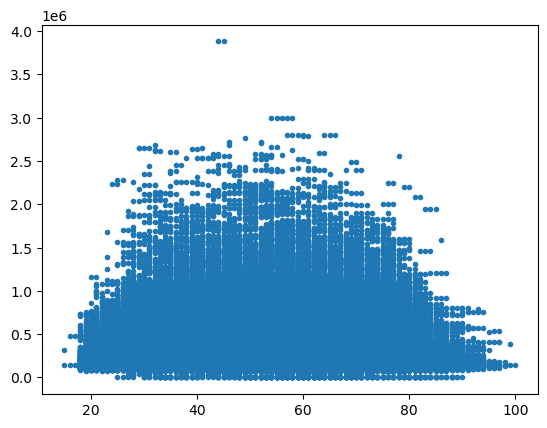

In [45]:
# plt.plot(df.customer_age, df.car_value, '.')

## Before using any algoritms, the data needs to be standardized

In [39]:
df

,policy_nr_hashed,years_since_policy_started,year_initiation_policy,year_initiation_policy_version,year_end_policy,d_churn,d_churn_cancellation,d_churn_between_prolongations,d_churn_around_prolongation,premium_main_coverages,...,welcome_discount_control_group_label,brand_label,type_label,fuel_type_label,product_label,sales_channel_label,policy_nr_hashed_label,cluster_k_means,cluster_k_means_2,cluster_agglomerative
0,JoRr68,13,2006,2019,2021.0,0,0,0,0,1887.648,...,3,62,602,1,0,2,45495,2,3,-1
1,JoRr68,14,2006,2020,2021.0,0,0,0,0,1978.592,...,3,62,602,1,0,2,45495,2,3,-1
2,JoRr68,15,2006,2021,2021.0,1,0,0,1,2206.064,...,3,62,602,1,0,2,45495,2,3,-1
3,L63zwL,13,2006,2019,NaN,0,0,0,0,1950.144,...,3,76,1289,1,0,2,50406,2,3,-1
4,L63zwL,14,2006,2020,NaN,0,0,0,0,2185.344,...,3,76,1289,1,0,2,50406,2,3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433635,70J0xA8,7,2011,2019,2023.0,0,0,0,0,1514.688,...,3,62,1415,1,2,2,19205,3,0,-1
433636,70J0xA8,8,2011,2020,2023.0,0,0,0,0,1698.816,...,3,62,1415,1,2,2,19205,3,0,-1
433637,70J0xA8,9,2011,2021,2023.0,0,0,0,0,1725.696,...,3,62,1415,1,2,2,19205,3,3,-1
433638,70J0xA8,10,2011,2022,2023.0,0,0,0,0,1778.112,...,3,62,1415,1,2,2,19205,3,3,-1


## Decide what variables to use for the ML methods

In [31]:
# Make 50/50 churn/no churn dataframe
df_churn = df[df.d_churn == 1.0]
df_no_churn = df[df.d_churn == 0.0]
reduced_df_no_churn = df_no_churn.sample(n=58394 , random_state=42)

# Merge the churn and sampled no churn df's
df_balanced = pd.concat([df_churn, reduced_df_no_churn], axis=0, ignore_index=True)
# df = new_df

# Data split using all data
X = df[["years_since_policy_started","year_initiation_policy","year_initiation_policy_version","premium_main_coverages",
        "premium_supplementary_coverages","total_premium","welcome_discount","customer_age","accident_free_years","car_value",
        "age_car","weight","allrisk basis","allrisk compleet","allrisk royaal","wa-extra","wettelijke aansprakelijkheid",
        "n_main_coverages","n_supplementary_coverages","n_coverages", "welcome_discount_control_group_label", "brand_label", 
        "type_label", "fuel_type_label", "product_label", "sales_channel_label","cluster_k_means", "cluster_k_means_2", 
        "cluster_agglomerative", "cluster_k_prototypes"]]

y_churn = df.d_churn
y_churn_cancellation = df.d_churn_cancellation
y_churn_between_prolongations = df.d_churn_between_prolongations
y_churn_around_prolongation = df.d_churn_around_prolongation

# Data Balanced
X_balanced = df_balanced[["years_since_policy_started","year_initiation_policy","year_initiation_policy_version","premium_main_coverages",
        "premium_supplementary_coverages","total_premium","welcome_discount","customer_age","accident_free_years","car_value",
        "age_car","weight","allrisk basis","allrisk compleet","allrisk royaal","wa-extra","wettelijke aansprakelijkheid",
        "n_main_coverages","n_supplementary_coverages","n_coverages", "welcome_discount_control_group_label", "brand_label", 
        "type_label", "fuel_type_label", "product_label", "sales_channel_label", "cluster_k_means", "cluster_k_means_2", 
        "cluster_agglomerative", "cluster_k_prototypes"]]

y_churn_balanced = df_balanced.d_churn
y_churn_cancellation_balanced = df_balanced.d_churn_cancellation
y_churn_between_prolongations_balanced = df_balanced.d_churn_between_prolongations
y_churn_around_prolongation_balanced = df_balanced.d_churn_around_prolongation

# # Randomly take 10% of the data the increase computation speed
# X_reduced, X_extra, y_reduced, y_extra = train_test_split(X, y, train_size=0.5, random_state=42)


## Before using any algoritms, the data needs to be standardized

In [28]:
# Standardize data

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the entire X dataframe's
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X_balanced.columns)

## Random Forest

In [32]:
# Performing a random split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_churn_balanced, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42,
                                            n_estimators=100,
                                            criterion='gini',
                                            max_depth=20,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            min_weight_fraction_leaf=0.0,
                                            max_features='sqrt',
                                            ccp_alpha=0.00)
random_forest_model.fit(X_train, y_train)

# Making predictions on the test set
predictions = random_forest_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.662
F1 Score: 0.620

Confusion Matrix:
[[9040 2532]
 [5355 6431]]


In [30]:
# Performing a random split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_churn, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42,
                                            n_estimators=100,
                                            criterion='gini',
                                            max_depth=20,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            min_weight_fraction_leaf=0.0,
                                            max_features='sqrt',
                                            ccp_alpha=0.00)
random_forest_model.fit(X_train, y_train)

# Making predictions on the test set
predictions = random_forest_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.891
F1 Score: 0.346

Confusion Matrix:
[[74776   239]
 [ 9215  2498]]


In [147]:
# Balanced
#Accuracy: 0.66
#F1 Score: 0.61

# Unbalanced
# Accuracy: 0.892
# F1 Score: 0.345

In [148]:
X_train

,years_since_policy_started,year_initiation_policy,year_initiation_policy_version,premium_main_coverages,premium_supplementary_coverages,total_premium,welcome_discount,customer_age,accident_free_years,car_value,...,wettelijke aansprakelijkheid,n_main_coverages,n_supplementary_coverages,n_coverages,welcome_discount_control_group_label,brand_label,type_label,fuel_type_label,product_label,sales_channel_label
30597,14,2007,2021,2184.000,4201.344,6385.344,1.0,32,8,304472.0,...,1,1,2,3,3,46,101,1,0,2
190505,6,2014,2020,3476.928,2745.792,6222.720,1.0,51,16,162780.8,...,1,1,1,2,3,46,52,4,3,2
126709,7,2014,2021,8921.472,260.736,9182.208,1.0,29,-1,141288.0,...,1,1,1,2,3,23,945,1,1,0
3125,19,2003,2022,2509.248,7373.184,9882.432,1.0,61,3,318808.0,...,1,1,3,4,3,33,1482,3,0,2
212428,1,2017,2019,6234.816,924.672,7159.488,1.0,54,15,502241.6,...,1,2,2,4,3,48,300,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,3,2019,2022,2565.696,732.480,3298.176,1.0,33,6,134624.0,...,1,2,1,3,0,58,20,1,1,2
365838,1,2022,2023,8135.232,865.536,9000.768,1.0,42,10,305088.0,...,1,2,1,3,0,67,1242,1,1,2
131932,8,2015,2023,5820.864,798.336,6619.200,1.0,34,8,405305.6,...,1,2,1,3,0,4,302,1,1,1
146867,5,2015,2020,4724.160,960.960,5685.120,1.0,48,12,405204.8,...,1,2,2,4,3,52,1254,1,1,2
